<a href="https://colab.research.google.com/github/stevenmaschan/nla-project/blob/main/cp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages import

In [ ]:
!pip install transformers
!pip install tensorly
!pip install sacrebleu
import torch
import torch.nn as nn
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from transformers import MarianMTModel, MarianTokenizer
from sacrebleu import sentence_bleu
from tensorly.decomposition import parafac
from tensorly.decomposition import CP
from tensorly.cp_tensor import cp_to_tensor
import torchvision.transforms as transforms
import torchvision
import tensorly as tl
tl.set_backend('pytorch')
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from transformers import ViTFeatureExtractor, ViTForImageClassification
from tqdm import tqdm
import time
import seaborn as sns
import sacrebleu
import copy
from sacrebleu.metrics import BLEU, CHRF, TER
from tqdm import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Compression Code

In [ ]:
class CPCompressedLinear(nn.Module):
    def __init__(self, original_weight, rank=2, bias=None):
        super(CPCompressedLinear, self).__init__()
        self.input_dim, self.output_dim = original_weight.shape

        self.cp_cores = parafac(original_weight, rank=rank)

        self.bias = nn.Parameter(bias) if bias is not None else None

    def reconstruct_weights(self):
        return cp_to_tensor(self.cp_cores)

    def forward(self, x):
        weights = self.reconstruct_weights()
        output = x @ weights.T
        if self.bias is not None:
            output += self.bias
        return output

In [ ]:
def cp_compress(model, rank=2):
    for name, layer in model.named_modules():
        if "classifier" in name:
            continue

        if isinstance(layer, nn.Linear):
            bias = layer.bias.data if layer.bias is not None else None

            with torch.no_grad():
                original_weight = layer.weight.data
                new_layer = CPCompressedLinear(
                    original_weight=original_weight,
                    bias=bias,
                    rank=rank
                )
                parent_module, layer_name = _get_parent_module(model, name)
                setattr(parent_module, layer_name, new_layer)
    return model

def _get_parent_module(model, module_name):
    parts = module_name.split(".")
    parent = model
    for part in parts[:-1]:
        parent = getattr(parent, part)
    return parent, parts[-1]

# Evaluation Code

In [ ]:
def translate(model, prompts, tokenizer):
    inputs = tokenizer(prompts, truncation=True, return_tensors="pt", padding=True)
    tokenized = inputs['input_ids'].to(device)
    outputs = model.generate(tokenized)
    decoded = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
    return decoded

def measure_time_and_quality(model, prompt, tokenizer):
    start_time = time.time()
    generated_text = translate(model, prompt, tokenizer)
    generation_time = time.time() - start_time
    return generated_text, generation_time

def measure_memory(model):
    total_params = sum(p.numel() for p in model.parameters())
    return total_params

# Translation

In [ ]:
prompts = [
    "Signaling systems transmit information within cells, between cells, between organs, between entire organisms, between populations of organisms, and even between different species in entire ecosystems.",
    "Thomas was an atheist. Now he is studying biochemistry and has become convinced that something like DNA and RNA molecules cannot be the product of natural laws and forces generated by the Big Bang.",
    "The fathers of modern science – Copernicus, Galileo, Kepler, Newton, Boyle, and many others – saw clear evidence of design in the universe and, in fact, were inspired to discover the laws of nature by their faith in a transcendent lawgive.",
    "J. J. Thomson and his son George Thomson were both awarded the Nobel Prize in Physics: the former in 1906 for demonstrating that the electron is a particle, and the latter in 1937 for showing that the electron is a wave.",
    "The first official contest for the title of World Chess Champion (a 24-game match) took place in New York, Saint Louis, and New Orleans between Wilhelm Steinitz (the winner) and Johannes Zukertort, in 1886.",
    "Of two balls of the same size (one made of iron, the other of wood) falling from the top of a tower, the iron one, because it has a greater gravitational charge (being heavier), is attracted with greater force, but, on the other hand, precisely because it has more mass (inertia), it offers greater resistance to falling. The result: both touch the ground at the same time, as Galileo demonstrated.",
    "Every spider is a versatile genius: It plans its web like an architect and then carries out this plan like the proficient weaver it is. It is also a chemist who can synthesize silk employing a computer-controlled manufacturing process, and then use the silk for spinning.",
    "The match for the FIDE 2023 World Chess Championship is tied (6 X 6), with Ding Liren (White) winning the twelfth game. Only two more games remain for one of the competitors to achieve the decisive advantage.",
    "If we see that Germany is winning the war we ought to help Russia, and if Russia is winning we ought to help Germany, and that way let them kill as many as possible, although I don't want to see Hilter victorious under any circumstances.",
    "Your Majesty, Ganon and his minions have released the coronavirus! \"Great, I'll grab my toilet paper.\" \"There is no time.\" \"How can we help?\" \"It is written: do NOT touch your face.\" \"Hmm... (The King rests his chin on his hand thoughtfully.) ...What?\" \"You're fucked.\" \"Oah! Link, save me!\" \"I guess I'd better get quarantined,\" Link says and flies away on a magic carpet.",
    "When I was little, I once broke my mom's favorite necklace, and all the little pieces spilled onto the road. \"Was she mad at you?\" \"I don't really remember.\" \"Then how do you know you did that?\" \"She told me about it several times.\" \"She's probably holding it against you.\" \"You think?\" \"Maybe. Once you start making money, you should buy her another one to make up for it.\" \"Alright, I will.\"",
]

references_list = [
    ["Сигнальные системы передают информацию внутри клеток, между клетками, между органами, между целыми организмами, между популяциями организмов и даже между различными видами в целых экосистемах."],
    ["Томас был атеистом. Теперь он изучает биохимию и убедился, что что-то вроде молекул ДНК и РНК не может быть продуктом естественных законов и сил, порожденных Большим взрывом."],
    ["Отцы современной науки – Коперник, Галилей, Кеплер, Ньютон, Бойль и многие другие – видели явные доказательства замысла во Вселенной и, по сути, были вдохновлены на открытие законов природы своей верой в трансцендентного законодателя."],
    ["Дж. Дж. Томсон и его сын Джордж Томсон были удостоены Нобелевских премий по физике: первый в 1906 году за демонстрацию того, что электрон является частицей, а второй в 1937 году за демонстрацию того, что электрон является волной."],
    ["Первое официальное соревнование за звание чемпиона мира по шахматам (матч из 24 игр) состоялось в 1886 году в Нью-Йорке, Сент-Луисе и Новом Орлеане между Вильгельмом Стейницем (победителем) и Йоханнесом Цукертортом."],
    ["Из двух шаров одинакового размера (один железный, другой деревянный), падающих с вершины башни, железный шар, поскольку он имеет больший гравитационный заряд (потому что он тяжелее), притягивается с большей силой, но, с другой стороны, именно благодаря большей массе (инерции) он оказывает большее сопротивление падению. В результате, оба касаются земли одновременно, как продемонстрировал Галилей."],
    ["Каждый паук - разносторонний гений: он планирует свою паутину, как архитектор, а затем осуществляет этот план, как искусный ткач. Он также является химиком, который может синтезировать шелк с помощью управляемого компьютером производственного процесса, а затем использовать его для прядения."],
    ["В матче за звание чемпиона мира ФИДЕ 2023 по шахматам ничья (6 X 6), Дин Лирен (белые) выиграла двенадцатую партию. Осталось еще две партии, чтобы один из участников добился решающего преимущества."],
    ["Если мы видим, что побеждает Германия, надо помочь России, а если побеждает Россия – надо помочь Германии, и таким образом позволить им убивать друг друга как можно больше, хотя победу Гитлера я не желаю видеть ни при каких обстоятельствах"],
    ["«Ваше Величество, Гэнон и его прислужники выпустили в мир коронавирус!» – «Здорово, я захвачу туалетную бумагу». – «Нет времени». – «Чем мы можем помочь?» – «Как написано: НЕ трогайте лицо». – «Хмм... (Король задумчиво подпирает рукой подбородок.) ...Что?» – «Вам пиздец». – «Ой! Линк, спаси меня!» – «Мне, верно, надо поместить себя в карантин», – говорит Линк и улетает прочь на ковре-самолёте."],
    ["Когда я был маленьким, я однажды порвал мамино любимое колье, и все маленькие бусины рассыпались по дороге. - \"Она тогда сильно на тебя разозлилась?\" - \"Я точно не помню\". \"Тогда откуда ты узнал эту историю?\" - \"Мама рассказывала мне ее несколько раз\". - \"Она, должно быть, до сих пор злится на тебя\". - \"Ты так считаешь?\" - \"Наверное. Когда ты станешь зарабатывать, ты должен купить ей другое, чтобы извиниться\". \"Хорошо, я так и сделаю\"."],
]

In [ ]:
model_name = "Helsinki-NLP/opus-mt-en-ru"
original_model = MarianMTModel.from_pretrained(model_name)
tokenizer = MarianTokenizer.from_pretrained(model_name)
original_model.to(device)

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(62518, 512, padding_idx=62517)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(62518, 512, padding_idx=62517)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLU()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,), eps=1e-05

In [132]:
ranks = [512, 430, 400, 362, 340, 320, 300, 280, 256, 128, 64]

compressed_bleu_scores = {}
compressed_times = {}
translations = {}
compressed_memories = {}


original_translation, original_time = measure_time_and_quality(original_model, prompts, tokenizer)
original_bleu_scores = [sentence_bleu(original_translation[i], references_list[i]).score for i in range(len(prompts))]
original_memory = measure_memory(original_model)


for rank in tqdm(ranks):
    compressed_model = cp_compress(copy.deepcopy(original_model), rank)
    compressed_model.to(device)
    compressed_translation, compressed_time = measure_time_and_quality(compressed_model, prompts, tokenizer)
    translations[rank] = compressed_translation
    scores = [sentence_bleu(compressed_translation[i], references_list[i]).score for i in range(len(prompts))]
    compressed_bleu_scores[rank] = scores
    compressed_times[rank] = compressed_time
    compressed_memories[rank] = measure_memory(compressed_model)

100%|██████████| 11/11 [04:08<00:00, 22.58s/it]


# Plots

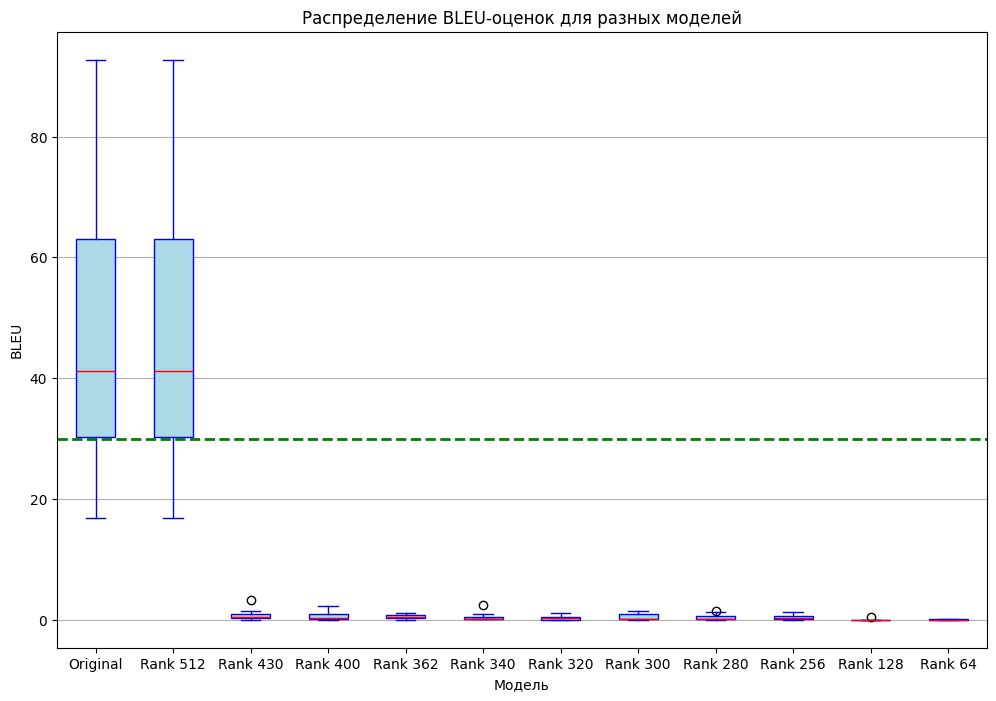

In [133]:
plt.figure(figsize=(12, 8))


plt.boxplot(
    [original_bleu_scores] + [compressed_bleu_scores[rank] for rank in ranks],
    labels=["Original"] + [f"Rank {r}" for r in ranks],
    patch_artist=True,
    boxprops=dict(facecolor="lightblue", color="blue"),
    medianprops=dict(color="red"),
    whiskerprops=dict(color="blue"),
    capprops=dict(color="blue"),
)
plt.xlabel("Модель")
plt.ylabel("BLEU")
plt.title("Распределение BLEU-оценок для разных моделей")
plt.axhline(y=30, color='green', linestyle='--', linewidth=2, label='BLEU = 30')
plt.grid(axis="y")
plt.show()

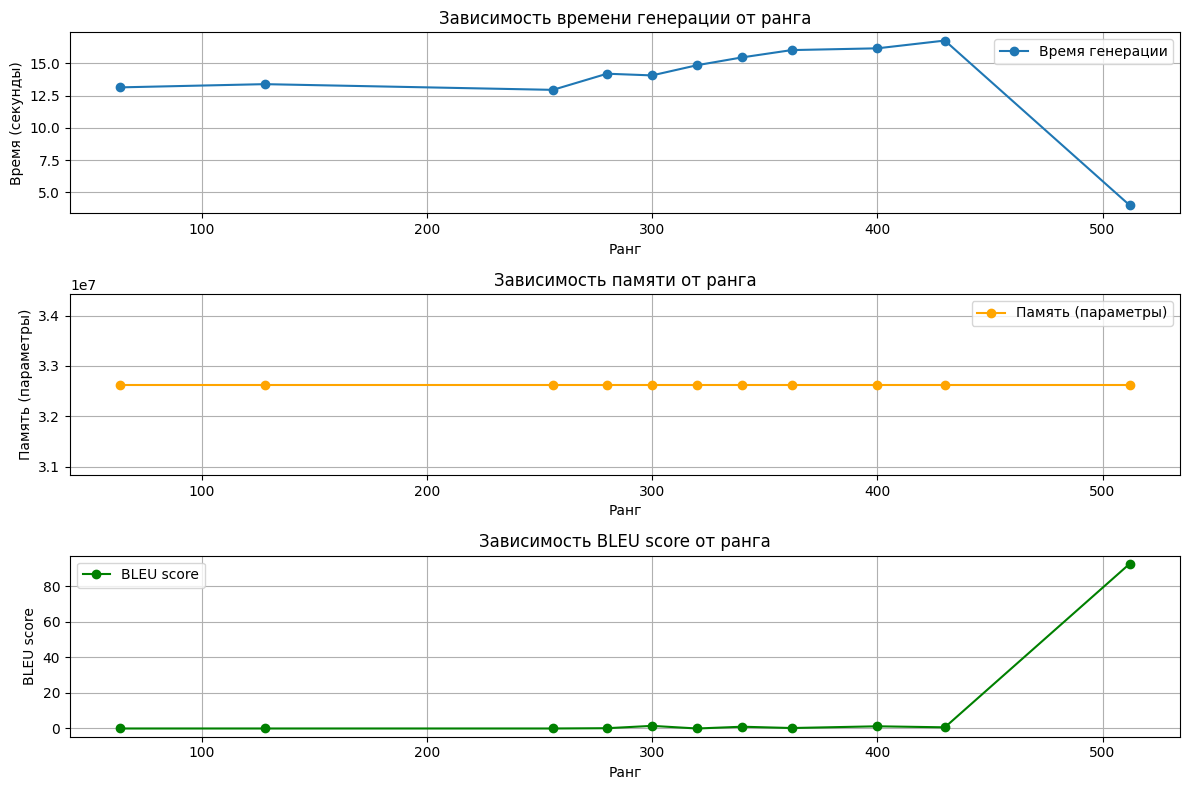

In [134]:
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(ranks, [compressed_times[rank] for rank in ranks], marker='o', label="Время генерации")
plt.xlabel("Ранг")
plt.ylabel("Время (секунды)")
plt.title("Зависимость времени генерации от ранга")
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(ranks, [compressed_memories[rank] for rank in ranks], marker='o', color='orange', label="Память (параметры)")
plt.xlabel("Ранг")
plt.ylabel("Память (параметры)")
plt.title("Зависимость памяти от ранга")
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(ranks, [compressed_bleu_scores[rank][0] for rank in ranks], marker='o', color='green', label="BLEU score")
plt.xlabel("Ранг")
plt.ylabel("BLEU score")
plt.title("Зависимость BLEU score от ранга")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()